Source: https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf

In [196]:
import pandas as pd
import scipy.io
import numpy as np
import glob
import os
from PIL import Image
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

root = 'C:/Users/augus/Documents/AI/datasets/four-shapes/shapes'

In [149]:
class Dataset:

    
    def __init__(
        self, 
        root, 
        img_shape=200,
        label_names={
            'circle': 0,
            'square': 1,
            'star': 2,
            'triangle': 3,
        },
        downsample = True,
        downsample_granularity = 4
    ):
        if img_shape%downsample_granularity:
            warnings.warn("Image shape is not divisible by downsample granularity. Sampling may be off-center")
        
        self.root = root
        self.fps = []
        self.data = []
        self.labels = []
        
        self.downsample = downsample
        # center downsampling
        downsampled_idxs = np.arange(0, img_shape, downsample_granularity)+downsample_granularity//2
        self.downsample_grid = tuple(np.meshgrid(downsampled_idxs, downsampled_idxs))
        
        # store map of shapes
        self.label_names = label_names
        
        # with the appropriate directory structure, this will read all the data filepaths
        for label in self.label_names:
            fps_of_class_i =  glob.glob(self.root + f'/{label}/**png')
            self.fps += glob.glob(self.root + f'/{label}/**png')
            # attach label to it
            self.labels += [self.label_names[label]] * len(fps_of_class_i)
        self.labels = np.array(self.labels)
            
    def downsample_img(self, img):
        """
        Simple downsampling for computational gain
        """
        return img[self.downsample_grid]
            
    def load_data(self):
        # read shape from file
        for fp in tqdm(self.fps):
            # convert png to np array
            img = np.asarray(
                    Image.open(fp)
                )
            
            if self.downsample:
                img = self.downsample_img(img)
                
            self.data.append(
                img.flatten()
            )
            
        self.data = np.array(self.data)
        # ensure equal # of labels and data
        assert self.data.shape[0] == self.labels.shape[0]
        

    def sample(self, n=100):
        """
        provide a size n random sample of data and labels from dataset
        args:
        - n (int): sample size
        """
        indices = np.random.choice(len(self.data), n)
        return self.data[indices], self.labels[indices]
    
    def __getitem__(self, i):
        """
        For easy indexing
        """
            
        return self.data[i], self.labels[i]
    
    def show(self, i=None, img=None):
        """
        show image of sample
        args:
        - i (int): index in dataset
        """
        if i is None and img is None:
            i = np.random.choice(self.data.shape[0])
        
        if img is None:
            img = self[i][0]
        
        square_img = img.reshape(int(np.sqrt(img.shape)), -1)
        
        Image.fromarray(square_img).show()
        return 
        
class PCA:
    
    def cov(self):
        
        return
    
    
    def __init__(self):
        return
    

In [248]:
dataset = Dataset(root, downsample_granularity=2)

In [249]:
dataset.load_data()

100%|██████████| 14970/14970 [00:08<00:00, 1789.44it/s]


In [261]:
# transpose data because we're correlating features, not samples
# self.data = self.data.T
sample = dataset.sample(1600)[0].T

In [262]:
# lambda eigenvalues, u eigenvectors
L, U = np.linalg.eig(np.cov(sample))
# all eigenvectors should be unit length
print("Lengths of first and last eigevector", np.matmul(U[:, 0].T, U[:, 0]), np.matmul(U[:, -1].T, U[:, -1]))

# drawback, very computationally expensive if not optimized ie doing manually like I am
# MemoryError: Unable to allocate 23.8 GiB for an array with shape (40000, 40000) and data type complex128
# can we solve this by downsampling? or forcing a smaller data type?


Lengths of first and last eigevector (0.999999999999998+0j) (1+0j)


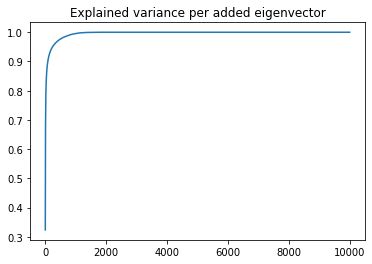

In [263]:
plt.plot(abs(np.cumsum(L)/np.sum(L)))
plt.title("Explained variance per added eigenvector")
plt.show()

In [264]:
abs(np.cumsum(L)/np.sum(L))

array([0.32340216, 0.39928853, 0.45738206, ..., 1.        , 1.        ,
       1.        ])

In [267]:
import plotly.graph_objects as go
fig = go.Figure(layout=dict(title = 'PCA Transformed Data'))

for key, val in dataset.label_names.items():
    sub_dataset = dataset[dataset[:][1] == val]
    pca_transformed = abs(np.matmul(sub_dataset[0], U[:, :3]) )
    fig.add_trace(go.Scatter3d(
        x = pca_transformed[:, 0],
        y = pca_transformed[:, 1],
        z = pca_transformed[:, 2],
        name = key,
        mode='markers'
    ))
fig.show()